In [2]:
import pandas as pd
import numpy as np

import bandeirante as bd
import datetime as dt

from matplotlib import pyplot as plt

import MetaTrader5 as mt5
mt5.initialize()

from hmmlearn.hmm import GaussianHMM

In [3]:
end = dt.datetime.today()#(2024,1,18)

start = end-dt.timedelta(days=365*5+1)

In [4]:
DI1_data = bd.MQLDataGet("DI1$",start,end,mt5.TIMEFRAME_D1)
DOL_data = bd.MQLDataGet("DOL$",start,end,mt5.TIMEFRAME_D1)
IFIX_data = bd.MQLDataGet("IFIX",start,end,mt5.TIMEFRAME_D1)
IBOV_data = bd.MQLDataGet("IBOV",start,end,mt5.TIMEFRAME_D1)

In [5]:
close_data = pd.DataFrame([(100-DI1_data["close"]),
    (DOL_data["close"]),
    IFIX_data["close"],
    IBOV_data["close"]
    ],index=["DI","DOL","IFIX","IBOV"]
    ).T

cdata_pct = close_data.pct_change().apply(np.log1p)
#cdata_pct["IBOV"] = -cdata_pct["IBOV"]

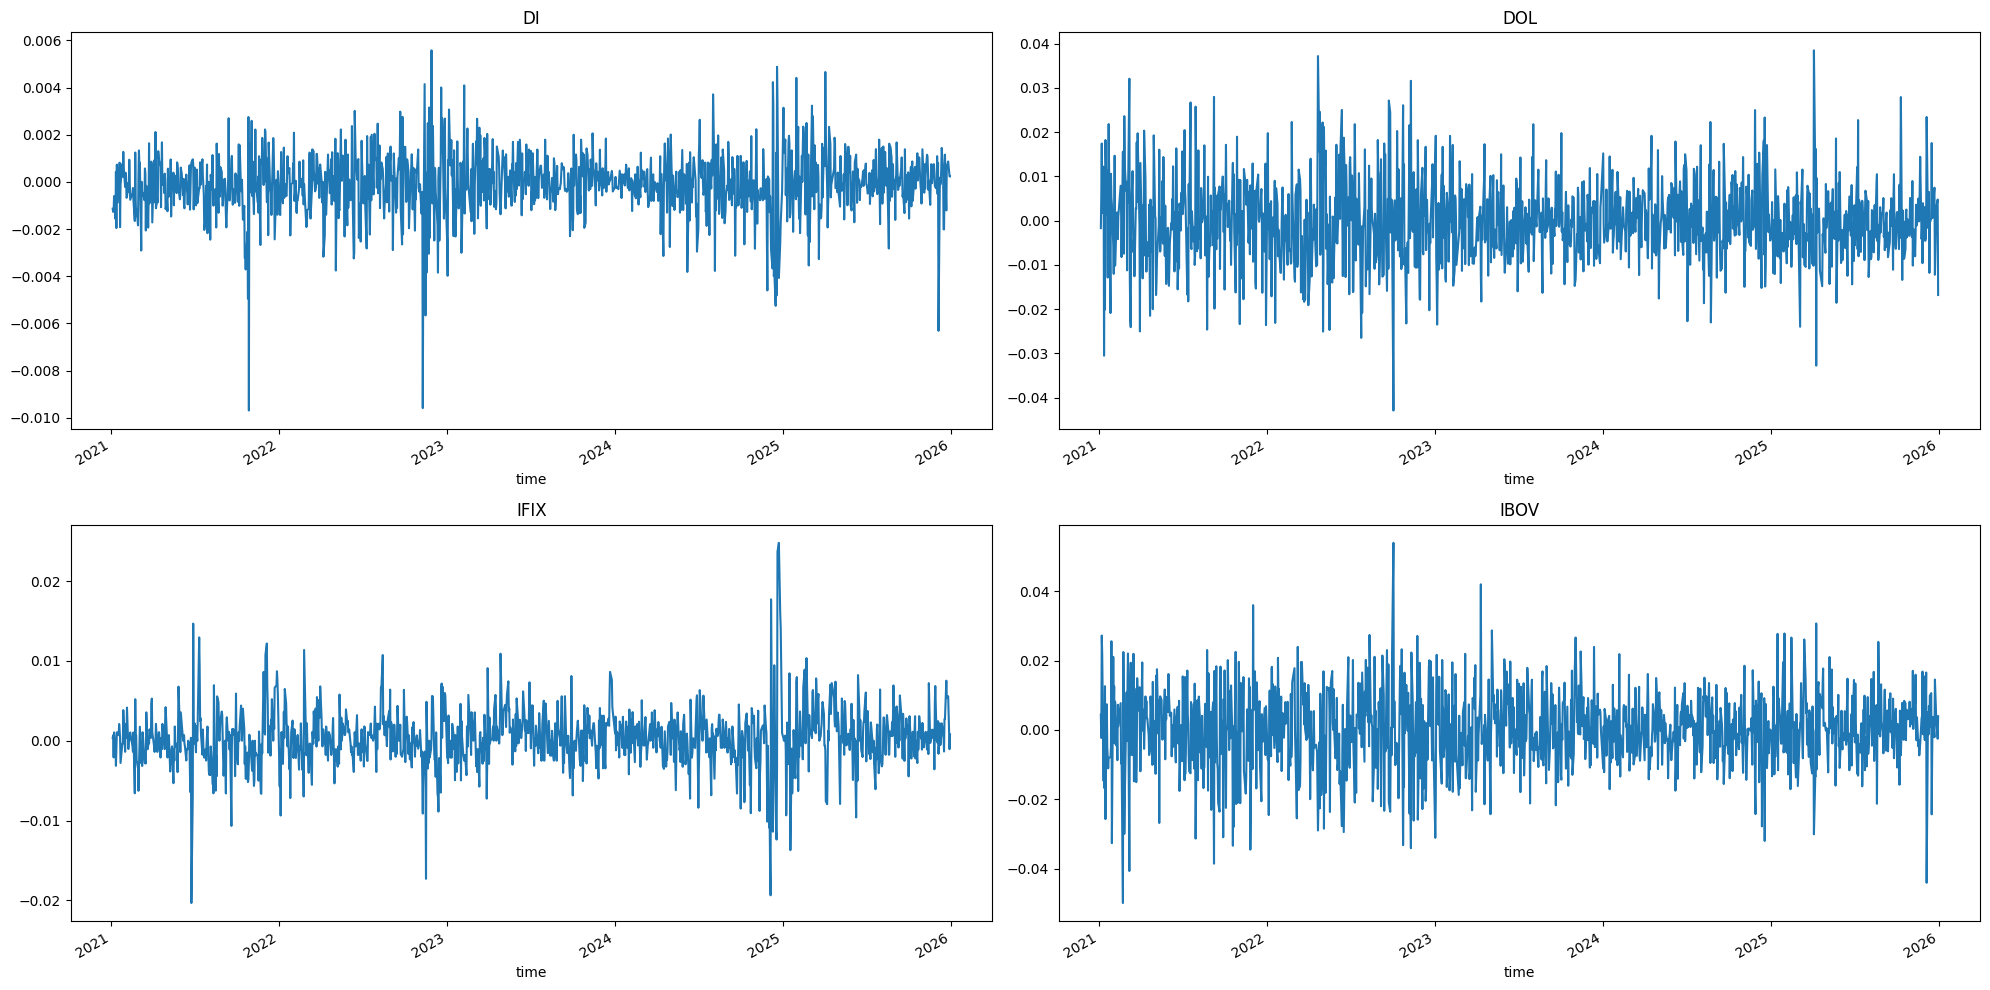

In [6]:
fig, axs = plt.subplots(2,2,figsize=(20,10))
axs_r = axs.ravel()
for index,column in enumerate(cdata_pct.columns):
    cdata_pct[column].plot(ax=axs_r[index])
    axs_r[index].set_title(column)

fig.tight_layout()

<Axes: xlabel='time'>

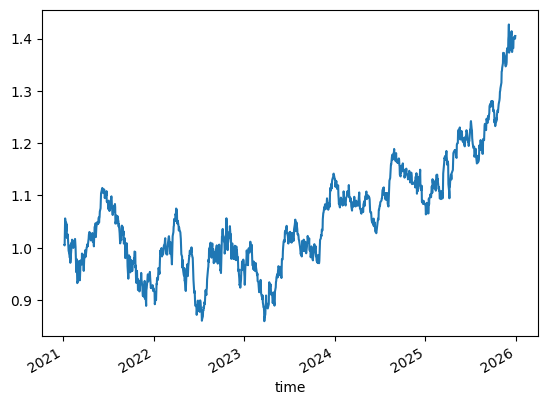

In [7]:
(cdata_pct["IBOV"]-cdata_pct["DI"]).add(1).cumprod().plot()
#(cdata_pct["DI"]).add(1).cumprod().plot()

In [8]:
correlation_with_ifix = cdata_pct[["DOL","DI","IBOV"]].rolling(21).corr(cdata_pct["IFIX"])

<Axes: xlabel='time'>

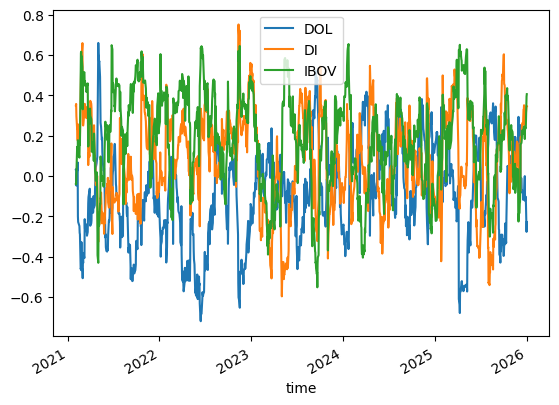

In [9]:
correlation_with_ifix.plot()

<Axes: xlabel='time'>

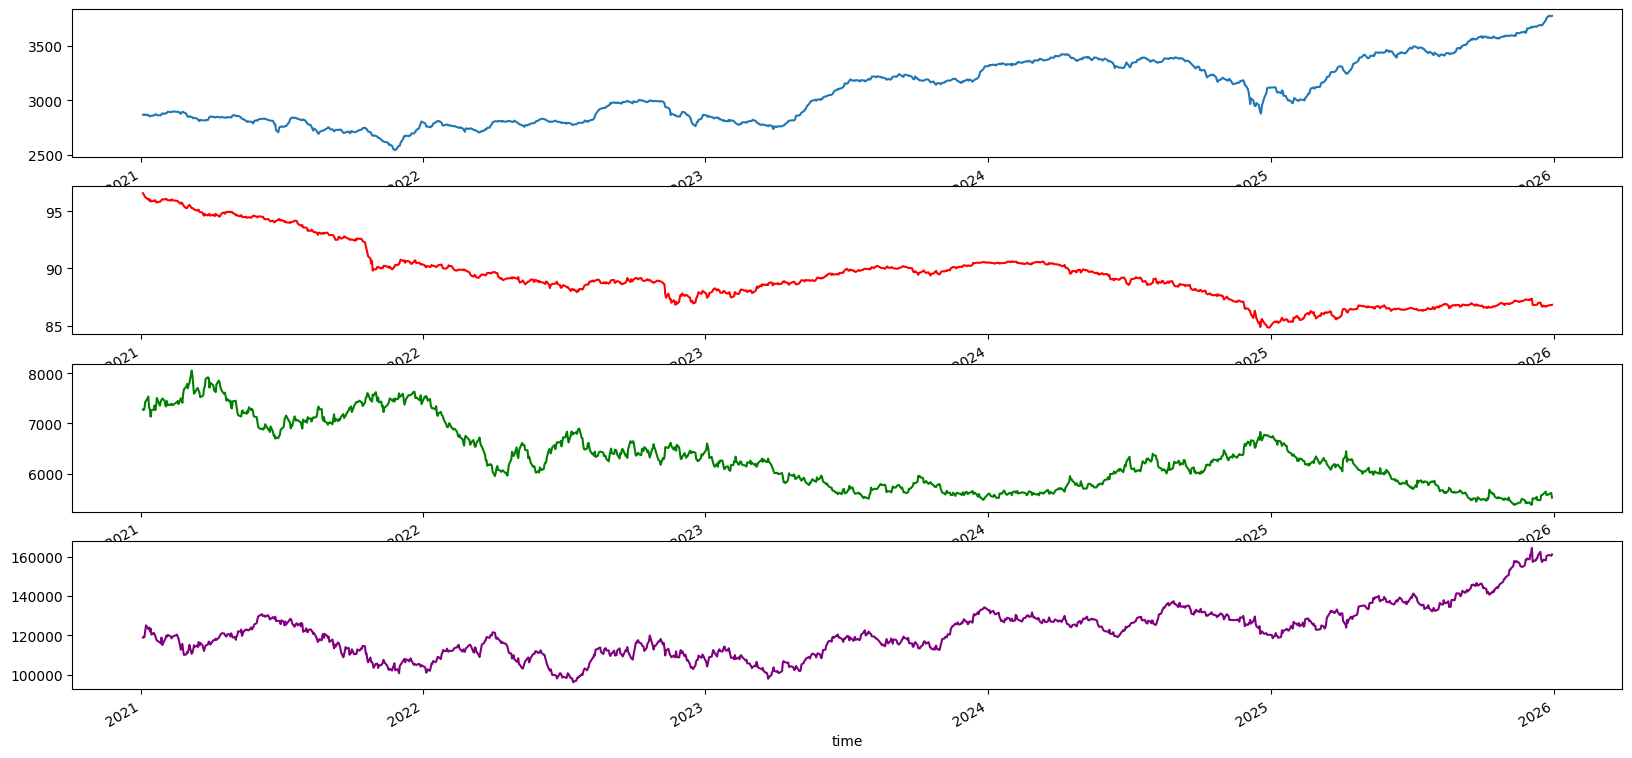

In [10]:
fig,axs = plt.subplots(4,1,figsize=(20,10))

close_data["IFIX"].plot(ax=axs[0])
(close_data["DI"]).plot(ax=axs[1],color="red")
#(correlation_with_ibov["DOL"]-correlation_with_ibov["DI"]).plot(ax=axs[1])
(close_data["DOL"]).plot(ax=axs[2],color="green")
(close_data["IBOV"]).plot(ax=axs[3],color="purple")

In [11]:
w = 15

IFIX_vol = bd.parkinson(IFIX_data,w,maxStr="high",minStr="low")
DOL_vol = bd.parkinson(DOL_data,w,maxStr="high",minStr="low")
DI1_vol = bd.parkinson(DI1_data,w,maxStr="high",minStr="low")

In [12]:
selected_data = "IFIX"
selected_vol = IFIX_vol

excess_ret = cdata_pct[selected_data]-cdata_pct[selected_data].ewm(span=w).mean()
excess_vol = selected_vol-selected_vol.ewm(span=w).mean()

snr = (cdata_pct[selected_data].ewm(span=w).mean()/selected_vol).dropna()



<Axes: xlabel='time'>

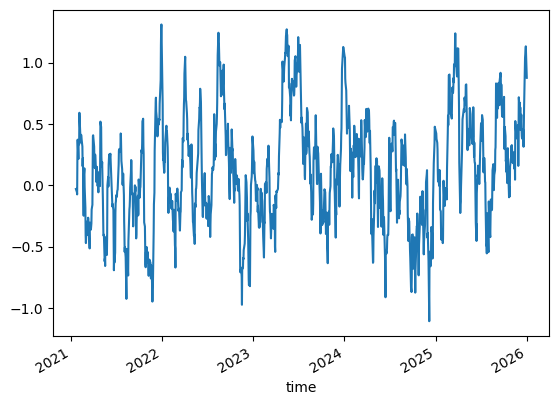

In [13]:
snr.plot()

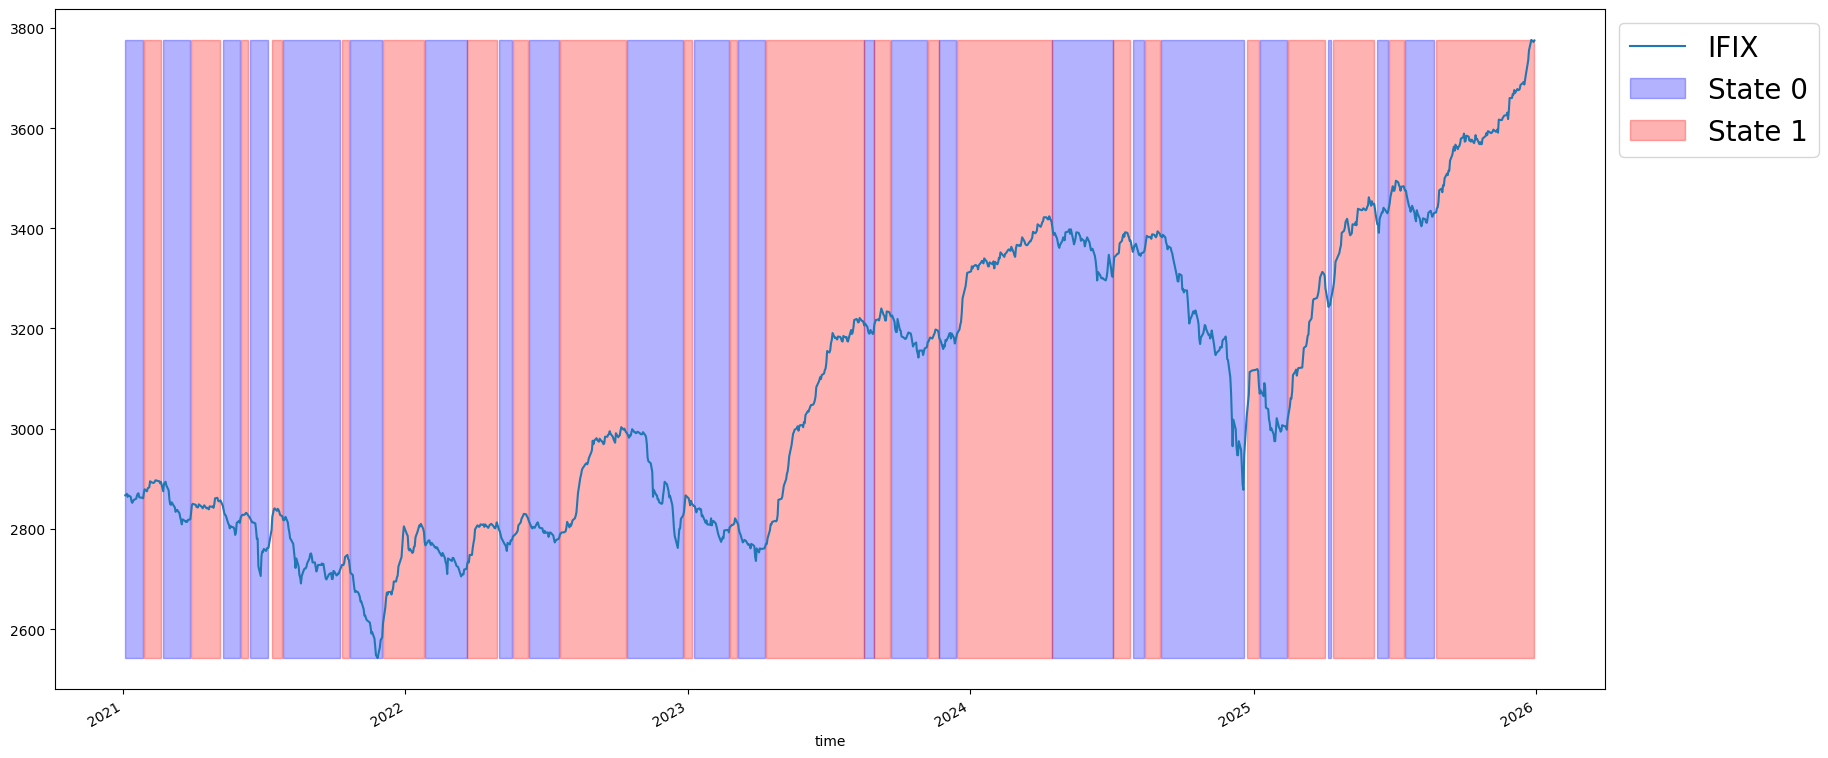

In [14]:
p = 2

model_hmm  = GaussianHMM(
    n_components=p,
    covariance_type="full",
    n_iter = 40,
    random_state = 19630626
    )

percentual = 0.75

snr_np = snr.to_numpy().reshape(-1,1)
train_data = snr_np[:np.ceil(snr_np.shape[0]*percentual).astype(int)]

model_hmm.fit(train_data)

close_data["State"] = 0
close_data.loc[snr.index,"State"] = model_hmm.predict(snr_np)

#close_data["State"] = close_data["State"].rolling(5).median()

close_data.loc[snr.index,"snr"] = snr

fig,axs = plt.subplots(1,1,figsize=(20,10))
close_data["IFIX"].plot(ax=axs)#hist(bins=50)
bd.OverFill(close_data,"IFIX","State",p,axs,"bwr")

In [40]:
observation_DI = bd.create_observation(DI1_data,close="close",open="open",high="high",low="low")
observation_DOL = bd.create_observation(DOL_data,close="close",open="open",high="high",low="low")
observation_index = bd.create_observation(IBOV_data,close="close",open="open",high="high",low="low")

In [70]:
observation_index["order"] = 0 


where_to_sell = (
    (observation_index["close"] > observation_index["plus_1sigma"]) 
    | 
    (observation_index["close"] > observation_index["plus_2sigma"])
)

where_to_buy = (
    (observation_index["close"] <= observation_index["minus_1sigma"]) 
    | 
    (observation_index["close"] < observation_index["minus_2sigma"])
)


observation_index.loc[where_to_buy,"order"] = 1
observation_index.loc[where_to_sell,"order"] = -1

In [66]:
# teste = pd.DataFrame([
# observation_DI["percentual"].apply(np.log1p),
# observation_DOL["percentual"].apply(np.log1p),
# observation_index["percentual"].apply(np.log1p)
# ]).T.dropna()


teste = observation_index["percentual"].apply(np.log1p)

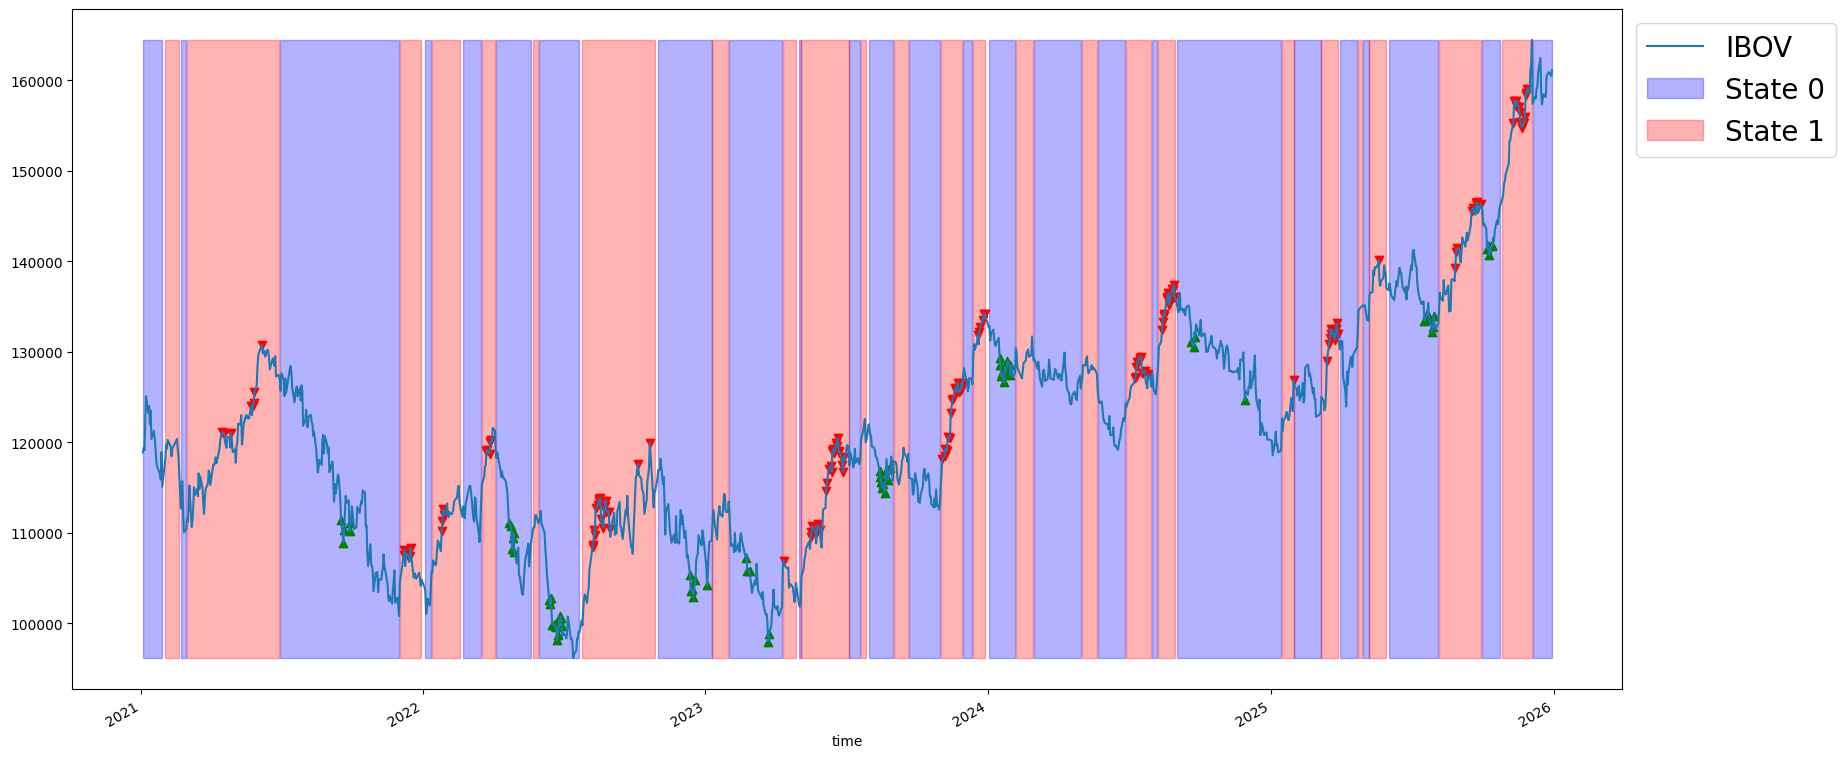

In [71]:
p = 2

model_hmm  = GaussianHMM(
    n_components=p,
    covariance_type="full",
    n_iter = 40,
    random_state = 0
    )

percentual = 0.75

snr_np = teste.dropna().to_numpy().reshape(-1,1)
train_data = snr_np[:np.ceil(snr_np.shape[0]*percentual).astype(int)]

model_hmm.fit(train_data)

close_data["State"] = 0
close_data.loc[teste.dropna().index,"State"] = model_hmm.predict(snr_np)

#close_data["State"] = close_data["State"].rolling(5).median()

close_data.loc[snr.index,"snr"] = snr

fig,axs = plt.subplots(1,1,figsize=(20,10))
close_data["IBOV"].plot(ax=axs)#hist(bins=50)
bd.OverFill(close_data,"IBOV","State",p,axs,"bwr")

axs.scatter(close_data.index[where_to_buy], close_data.loc[where_to_buy,"IBOV"], c="green", marker="^")
axs.scatter(close_data.index[where_to_sell], close_data.loc[where_to_sell,"IBOV"], c="red", marker="v")



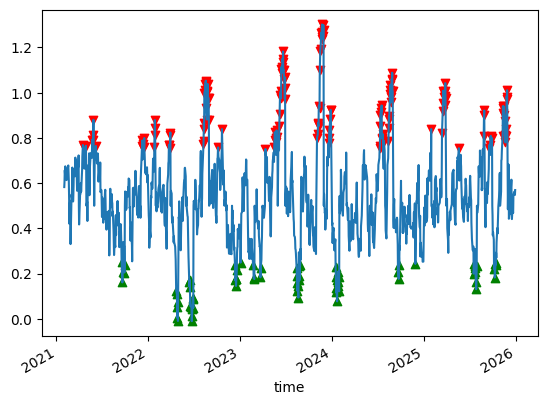

In [76]:
observation_index["percentual"].plot()

plt.scatter(observation_index.index[where_to_buy], observation_index.loc[where_to_buy,"percentual"], c="green", marker="^")
plt.scatter(observation_index.index[where_to_sell], observation_index.loc[where_to_sell,"percentual"], c="red", marker="v")


In [53]:
close_data.index[where_to_buy].shape
close_data.loc[where_to_buy].shape

(73, 6)

In [20]:
from statsmodels.tsa.ar_model import AutoReg

model = AutoReg(teste.pct_change(1).add(1).apply(np.log).dropna().to_numpy(), lags=5, old_names=False)
res = model.fit()

print(res.params)



TypeError: can only concatenate list (not "str") to list